# Fine-tuning pretrained BERT model for text classification

In this notebook, I will fine-tune pretrained BERT model for text classification for sentiment analysis of user comments
using dataset provided by Hugging Face

## Install Transformers and datasets

In [ ]:
! pip install datasets evaluate
! pip install -U accelerate transformers

## Load the dataset

I will be using English subset of the sentiments dataset from the following link:

https://huggingface.co/datasets/tyqiangz/multilingual-sentiments

In [2]:
from datasets import load_dataset

dataset = load_dataset("tyqiangz/multilingual-sentiments", "english")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1839 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/324 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/870 [00:00<?, ? examples/s]

## Check the dataset

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 1839
    })
    validation: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 324
    })
    test: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 870
    })
})

In [4]:
dataset['train'][99]

{'text': '@user TMILLS is going to Tucson! But the 29th and it\\u2019s on a Thursday :( ',
 'source': 'sem_eval_2017',
 'label': 2}

In [5]:
dataset['train'][300]

{'text': '"There\'s a lot of stupid $h!t out there, but polling Trump v Kanye West may take the cake. All I can think to say is: #$%#$%$#%#$%#$%#$#$#$%" ',
 'source': 'sem_eval_2017',
 'label': 2}

In [6]:
dataset['train'].features

{'text': Value(dtype='string', id=None),
 'source': Value(dtype='string', id=None),
 'label': ClassLabel(names=['positive', 'neutral', 'negative'], id=None)}

There are 3 class labels from 0 to 2 and they corresponds to labels as follows:

In [7]:
for i in range(3):
  print(i, dataset['train'].features['label'].int2str(i))

0 positive
1 neutral
2 negative


Formatting the dataset as pandas dataframe for now to look into label column

In [8]:
dataset.set_format(type='pandas')

train_df = dataset['train'][:]
train_df.head()

,text,source,label
0,okay i\u2019m sorry but TAYLOR SWIFT LOOKS NOT...,sem_eval_2017,2
1,@user the DC comics site has Batman 44 release...,sem_eval_2017,1
2,"""Frank Gaffrey\u002c Cliff May\u002c Steve Eme...",sem_eval_2017,0
3,The tragedy of only thinking up hilarious twee...,sem_eval_2017,2
4,"""Oliseh meets with Victor Moses in London: Sup...",sem_eval_2017,1


In [9]:
train_df.value_counts(['source', 'label'])

source         label
sem_eval_2017  0        613
               1        613
               2        613
dtype: int64

All data in the dataset is from the mutual source and class labels are evenly distributed

In [10]:
dataset.reset_format()

## Pretrained model and tokenizer

In [11]:
from transformers import AutoTokenizer

model_ckpt = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Checking how the tokenizer works

In [12]:
sample_text = dataset['train'][300]['text']

print(sample_text)

"There's a lot of stupid $h!t out there, but polling Trump v Kanye West may take the cake. All I can think to say is: #$%#$%$#%#$%#$%#$#$#$%" 


In [13]:
sample_text_tokenized = tokenizer(sample_text)
print(sample_text_tokenized)

{'input_ids': [101, 107, 1247, 112, 188, 170, 1974, 1104, 4736, 109, 177, 106, 189, 1149, 1175, 117, 1133, 20990, 8499, 191, 14812, 3382, 1162, 1537, 1336, 1321, 1103, 10851, 119, 1398, 146, 1169, 1341, 1106, 1474, 1110, 131, 108, 109, 110, 108, 109, 110, 109, 108, 110, 108, 109, 110, 108, 109, 110, 108, 109, 108, 109, 108, 109, 110, 107, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [14]:
len(sample_text_tokenized)

3

In [15]:
sample_text_tokenized.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

Now applying the tokenizer to the whole dataset

In [16]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

dataset_tokenized = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/1839 [00:00<?, ? examples/s]

Map:   0%|          | 0/324 [00:00<?, ? examples/s]

Map:   0%|          | 0/870 [00:00<?, ? examples/s]

In [17]:
dataset_tokenized

DatasetDict({
    train: Dataset({
        features: ['text', 'source', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1839
    })
    validation: Dataset({
        features: ['text', 'source', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 324
    })
    test: Dataset({
        features: ['text', 'source', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 870
    })
})

In [20]:
import torch
from transformers import AutoModelForSequenceClassification

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 3

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [22]:
from transformers import TrainingArguments

batch_size = 16
logging_steps = len(dataset_tokenized["train"]) // batch_size
model_name = "text-classification"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

In [23]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset_tokenized["train"],
    eval_dataset=dataset_tokenized["validation"],
    tokenizer=tokenizer
)

In [25]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.010200,0.823775,0.611111,0.567647
2,0.766200,0.739724,0.660494,0.648385


TrainOutput(global_step=230, training_loss=0.886519479751587, metrics={'train_runtime': 55.5409, 'train_samples_per_second': 66.222, 'train_steps_per_second': 4.141, 'total_flos': 151207992250560.0, 'train_loss': 0.886519479751587, 'epoch': 2.0})

## Evalulation of the fine-tuned model

Both accuracy and F1 scores are not high assuming due to the small size of the dataset used,

better scores are expected if larger dataset is used to fine-tune the pretrained model

In [27]:
preds_output = trainer.predict(dataset_tokenized["validation"])

Visualize the Confusion Matrix

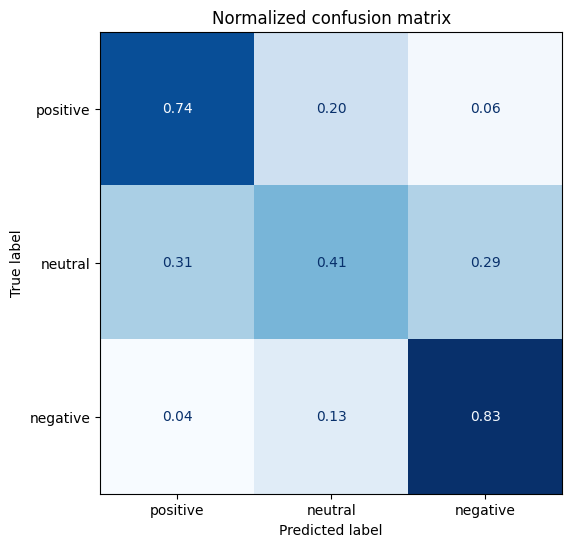

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(dataset_tokenized["validation"]["label"])
labels = dataset_tokenized["train"].features["label"].names

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)

The fine-tuned model is able to predict the positive and negative class lables significantly better than neutral label

The model is very unlikely to label negative label as positive and vice versa

## Saving the fine-tuned model

I will save the label names with the model

In [40]:
id2label = {}
for i in range(dataset["train"].features["label"].num_classes):
    id2label[i] = dataset["train"].features["label"].int2str(i)

label2id = {}
for i in range(dataset["train"].features["label"].num_classes):
    label2id[dataset["train"].features["label"].int2str(i)] = i

trainer.model.config.id2label = id2label
trainer.model.config.label2id = label2id

In [42]:
trainer.save_model('text_classification')

## Testing with the fine-tuned model

In [43]:
new_tokenizer = AutoTokenizer.from_pretrained("text_classification")

new_model = AutoModelForSequenceClassification.from_pretrained("text_classification")

In [46]:
sample_text = "@user Everyone's thinking far too short-termed. When all fossil fuels run out with no substitutes, then the crisis will come."

In [47]:
print(sample_text)

@user Everyone's thinking far too short-termed. When all fossil fuels run out with no substitutes, then the crisis will come.


In [48]:
inputs = new_tokenizer(sample_text, return_tensors="pt")

new_model.eval()

with torch.no_grad():
    outputs = new_model(
        inputs["input_ids"],
        inputs["attention_mask"],
    )
outputs.logits

tensor([[-0.9138,  0.1207,  1.2529]])

Now get the predicted class label from the returned logits

In [49]:
y_preds = np.argmax(outputs.logits.to('cpu').detach().numpy().copy(), axis=1)
def id2label(x):
    return new_model.config.id2label[x]
y_dash = [id2label(x) for x in y_preds]
y_dash

['negative']

The fine-tuned model predicted the label correctly